In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd

import seaborn as sn
import matplotlib.pyplot as plt

import glob
import os
from statsbombpy import sb

# Application Analysis
## Input requirements for this notebook:
- The list of match_id for all matches in Euro 2020 from Statsbomb open data.
- Line-up and event data
- master_data_analysis.json

In [4]:
#this dir only used to get list of files, can change to just a normal list
sample_path_360 = "C:/Users/Huy's/OneDrive/1_school/qmul_2021-22/project/open-data-master/data/three-sixty/*.json"
#these dirs are where the event and lineup files are located
sample_path_events = "C:/Users/Huy's/OneDrive/1_school/qmul_2021-22/project/open-data-master/data/events/"
sample_path_lineup = "C:/Users/Huy's/OneDrive/1_school/qmul_2021-22/project/open-data-master/data/lineups/"

files = [os.path.basename(x).split('.')[0] for x in glob.glob(sample_path_360)]

In [18]:
master_data = pd.read_json("master_data_analysis.json")

## Generate all players' and teams' playing minutes
- This is done by getting each team line up, all substitutions event in each match, and the maximum minute of each match

In [5]:
columns = ['id', 'match_id', 'team.id', 'team.name', 'position.name', 'play_pattern.name', 'player.id', 'player.name',
           'pass.type.id', 'possession']
pass_info=[]
match_info=[]
lineup_df = []
subs_df = []
i=0
for match in files:
    event_file = sample_path_events + match + ".json"
    with open(event_file, 'r', encoding='utf-8') as file:
        df = json.load(file)
    df = pd.json_normalize(df)
    df['match_id'] = match
    
    match_df = df.groupby(['match_id'])['minute'].max()
    match_info.append(match_df)
    
    event_df = df.loc[df['type.name']=='Pass', columns]
    pass_info.append(event_df)
    
    match_lineup = df.loc[df['type.name']=='Starting XI', 'tactics.lineup']
    team_name = df.loc[df['type.name']=='Starting XI', 'team.name']


    for x in range(2):
        lineup = pd.json_normalize(match_lineup[x])
        lineup['team']=team_name.loc[x]
        lineup['minute']=0
        lineup['match_id']=match
        lineup_df.append(lineup[['match_id','team', 'player.id', 'minute']])

    subs = df.loc[df['type.name']=='Substitution', ['match_id','team.name','player.id', 'substitution.replacement.id', 'minute']]
    subs_df.append(subs)
    
    i+=1
    print(i)
    
event_data = pd.concat(pass_info).set_index('id')
match_info = pd.concat(match_info)
lineup_df = pd.concat(lineup_df)
subs_df = pd.concat(subs_df)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51


In [7]:
#rename columns for easier mapping
event_data.rename(columns={'team.id': 'team_id', 'team.name': 'team', 'position.name':'position', 
                           'play_pattern.name':'play_pattern', 'pass.type.id':'pass_type'}, inplace=True)
lineup_df.rename(columns={'player.id': 'player_id', 'minute': 'start_minute'}, inplace=True)
subs_df.rename(columns={'player.id': 'player_id','team.name': 'team', 
                        'minute': 'sub_minute', 'substitution.replacement.id':'replace_id'}, inplace=True)

match_info = pd.DataFrame(match_info)
match_info.rename(columns={'minute': 'end_minute'}, inplace=True)

#### Create tables of subs_in and tables of subs_out

In [8]:
#get sub in and sub out tables
sub_in_df = subs_df[['match_id', 'team', 'replace_id', 'sub_minute']].rename(columns=
                                                                             {'sub_minute':'start_minute',
                                                                              'replace_id':'player_id'})
sub_out_df = subs_df.set_index(['player_id', 'match_id'])

#### The table consisting of line-up is concatenated with subs_in; this table is then joined with table subs_out and match_info (containing total match minutes) to extract total minute each player played in each match.

In [9]:
#concat starting lineup with sub in table
all_player = pd.concat([lineup_df, sub_in_df], axis=0)
#join sub ou table with the just created table
all_player = all_player.set_index(['player_id', 'match_id']).join(sub_out_df[['sub_minute']], how='left').reset_index()
#get match_end minutes
all_player = all_player.join(match_info, on='match_id')
#get played minutes for each player
all_player['played_minutes'] =np.where(all_player['sub_minute'].isnull(), all_player['end_minute']-all_player['start_minute'],
                                       all_player['sub_minute']-all_player['start_minute'])

- Team minutes can then be retrieved by getting the max number of minutes their players played in 

In [10]:
team_match_minutes = all_player.groupby(['match_id', 'team'])['played_minutes'].max()
# team_match_minutes
team_minutes = team_match_minutes.reset_index().groupby(['team'])['played_minutes'].sum()

#### Joining player and team identifiers with the master data that contains our model output

In [24]:
pass_analysis = master_data.join(event_data)
pass_analysis.describe()


0.8129770021317521

#### Create new features called dangerous pass and risky pass (75% percentile for each metric)

In [ ]:
pass_danger_thres = pass_analysis['x_chance'].quantile(0.75)
pass_risky_thres = pass_analysis['x_pass'].quantile(0.25)
pass_analysis['flag_danger_pass'] = np.where(pass_analysis['x_chance']> pass_danger_thres, 1, 0)
pass_analysis['flag_risky_pass'] = np.where(pass_analysis['x_pass']< pass_risky_thres, 1, 0)


pass_risky_thres

#### Zones of the pitch
- divide the pitch into 18 zones

In [25]:

def get_zones(x, y):
    assert x<=120 and y<=80, "Value has to be between 120 for x and 80 for y"
    zones = {}
    for i in range(18):
        x_lim=((i//3+1)*20)
        y_lim=((3 if ((i+1)%3)==0 else ((i+1)%3))*(80/3))
        zones[i+1] = [x_lim, y_lim]
    for coor in zones:
        if (x<=zones[coor][0])&(y<=zones[coor][1]):    
            break
        else:
            continue
    return coor

#test
x = 120
y = 4
get_zones(x, y)

16

- Get vertical and horizontal area of the pitch (deprecated)

In [26]:
def vert_area(zone):
    if zone<7:
        return 'back'
    elif zone<13:
        return 'mid'
    else:
        return 'final third'

def horiz_area(zone):
    if (zone%3==1) or (zone%3==0):
        return 'flank'
    else:
        return 'centre'

- Get each pass position zone (pass origination and pass receipt)

In [27]:
pass_analysis['pass_loc_zone'] = pass_analysis.apply(lambda row:
                                                    get_zones(row['pass_loc_x'], 
                                                              row['pass_loc_y']), axis=1)
pass_analysis['pass_receipt_zone'] = pass_analysis.apply(lambda row:
                                                    get_zones(row['pass_receipt_loc_x'], 
                                                              row['pass_receipt_loc_y']), axis=1)

# pass_analysis['pass_loc_vert_area']=pass_analysis.apply(lambda x: vert_area(x['pass_loc_zone']), axis=1)
# pass_analysis['pass_loc_horiz_area']=pass_analysis.apply(lambda x: horiz_area(x['pass_loc_zone']), axis=1)

# pass_analysis['pass_receipt_vert_area']=pass_analysis.apply(lambda x: vert_area(x['pass_receipt_zone']), axis=1)
# pass_analysis['pass_receipt_horiz_area']=pass_analysis.apply(lambda x: horiz_area(x['pass_receipt_zone']), axis=1)


#### Create a reusable group_by function

In [311]:
def f(x):
    d = {}
    d['x_pass'] = (x['x_pass']).sum()
    d['x_danger'] = (x['x_chance']).sum()
    d['count_pass'] = (x['binary_pass_risk']).count()
    d['pass_completed'] = (x['binary_pass_risk']).sum()
    d['pass_lead_chance'] = (x['binary_pass_reward']).sum()
    d['no_dangerous_pass'] = (x['flag_danger_pass']).sum()
    d['no_risky_pass'] = (x['flag_risky_pass']).sum()
    d['no_risky_pass_completed'] = (x['flag_risky_pass']&x['binary_pass_risk']).sum()
    d['no_match'] = (x['match_id']).nunique()
    return pd.Series(d, index=['x_pass', 'x_danger', 'pass_completed',
                               'pass_lead_chance', 'no_dangerous_pass', 'no_risky_pass','no_risky_pass_completed',
                               'count_pass', 'no_match'])



In [313]:
def group_by(input_df, group_by_col):
    df = input_df.groupby(group_by_col).apply(f)
    df['x_pass_added'] = df['pass_completed'] - df['x_pass']
    df['x_danger_added'] = df['pass_lead_chance'] - df['x_danger']
    #get playing minutes for each team
#     df = df.join(team_minutes, how='left')
    df['pass_risk_perc'] = 1-df['x_pass']/df['count_pass']
    df['pass_danger_perc'] = df['x_danger']/df['count_pass']
    df['perc_risky_pass'] = df['no_risky_pass']/df['count_pass']
    df['risky_pass_completion'] = df['no_risky_pass_completed']/df['no_risky_pass']
    df['perc_dangerous_pass'] = df['no_dangerous_pass']/df['count_pass']
    return df

## Team analysis
- group passing statistics by team and join to get playing minutes

In [31]:
team_perf = group_by(pass_analysis, 'team')
team_perf = team_perf.join(team_minutes, how='left')

- Add percentage pass risk / danger / completed / leading to chance

In [165]:
team_perf['perc_x_pass_add'] = team_perf['x_pass_added'] / team_perf['count_pass']
team_perf['perc_x_danger_add'] = team_perf['x_danger_added'] / team_perf['count_pass']
team_perf['perc_pass_completed'] = team_perf['pass_completed'] / team_perf['count_pass']
team_perf['perc_pass_lead_chance'] = team_perf['pass_lead_chance'] / team_perf['count_pass']

- Add number of pass risk / danger / completed / leading to chance per 90

In [33]:
team_perf['pass_count_p90'] = team_perf['count_pass'] *90 / team_perf['played_minutes']
team_perf['pass_completed_p90'] = team_perf['pass_completed'] *90 / team_perf['played_minutes']
team_perf['pass_lead_chance_p90'] = team_perf['pass_lead_chance'] *90/ team_perf['played_minutes']
team_perf['x_pass_p90'] = team_perf['x_pass'] *90/ team_perf['played_minutes']
team_perf['x_danger_p90'] = team_perf['x_danger'] *90/ team_perf['played_minutes']
team_perf['x_pass_added_p90'] = team_perf['x_pass_added'] *90/ team_perf['played_minutes']
team_perf['x_danger_added_p90'] = team_perf['x_danger_added'] *90/ team_perf['played_minutes']

### Plotting:
- Create reusable plotting thingy

In [162]:


def sub_plot_team(df, ax, metric, metric_name, percentage, y_label='%', top_n=5, ascending=False, color='grey'):

    df = df.sort_values(metric, ascending=ascending)
    df_top = pd.concat([df.head(top_n), df.tail(top_n)])
    labels = df_top.index.to_list()
    values = [ float('%.2f' % elem ) for elem in (df_top[metric]*np.where(percentage, 100, 1)).to_list()]
    x = np.arange(len(labels))  # the label locations
    rects1 = ax.bar(x,values,  
                    label=metric_name,
                    color=color)
    # rects2 = ax.bar(x + width/2, team_perf_xpass['perc_x_danger_add']*100, width, label='Percentage of added danger from pass')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(y_label, size=13)
    ax.set_title(f'Top and bottom {top_n} teams for {metric_name}', size=17)
    ax.set_xticks(x)

    ax.set_xticklabels(labels, size=14)
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # ax.legend()
    ax.set_facecolor('white')
    
    ax.bar_label(rects1, padding=-15, color='white', size=11.5)
    # ax.bar_label(rects2, padding=3)

    # fig.tight_layout()

#### Pass risk analysis

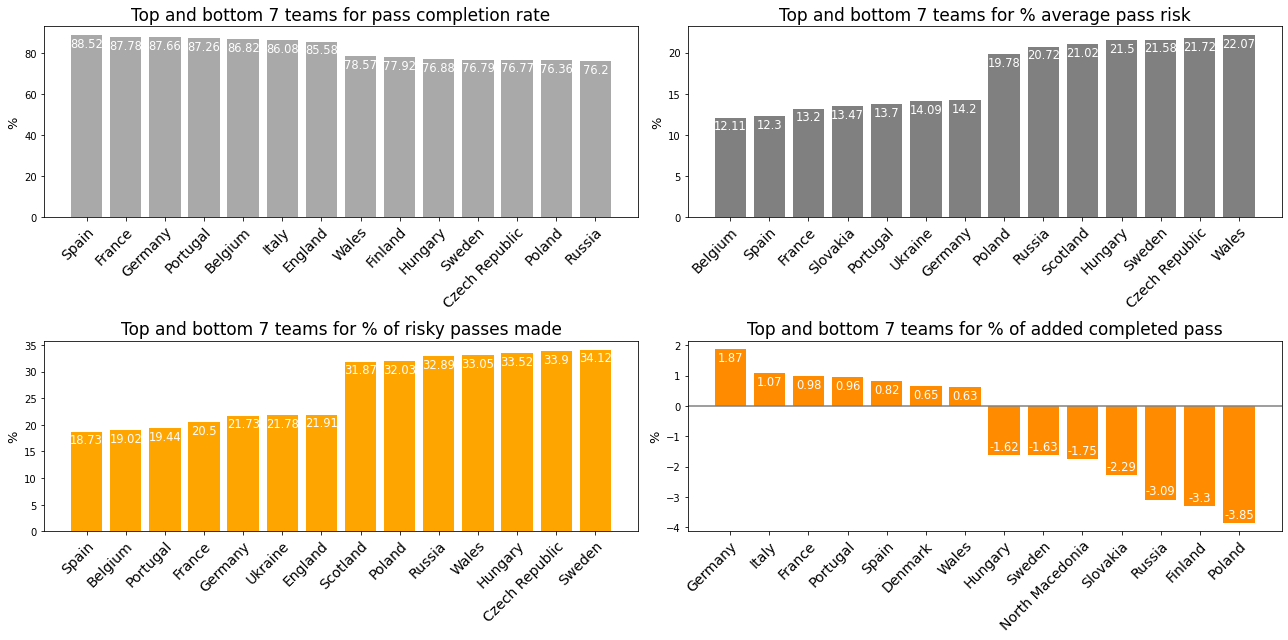

In [183]:
fig, axs = plt.subplots(2, 2, figsize=(18, 9))
sub_plot_team(team_perf, axs[0,0], 
              'perc_pass_completed', 'pass completion rate', True,top_n=7, color='darkgrey')
sub_plot_team(team_perf, axs[0,1], 
              'pass_risk_perc', '% pass risk', True, 
              ascending=True, top_n=7, color='grey')
sub_plot_team(team_perf, axs[1,0], 
              'perc_risky_pass', '% of risky passes made', True, 
              ascending=True,top_n=7, color='orange')
sub_plot_team(team_perf, axs[1,1], 
              'perc_x_pass_add', '% of added completed pass', True,top_n=7, color='darkorange')
plt.axhline(y=0, color='grey', linestyle='-')
fig.tight_layout()
plt.show()

#### Pass reward  analysis

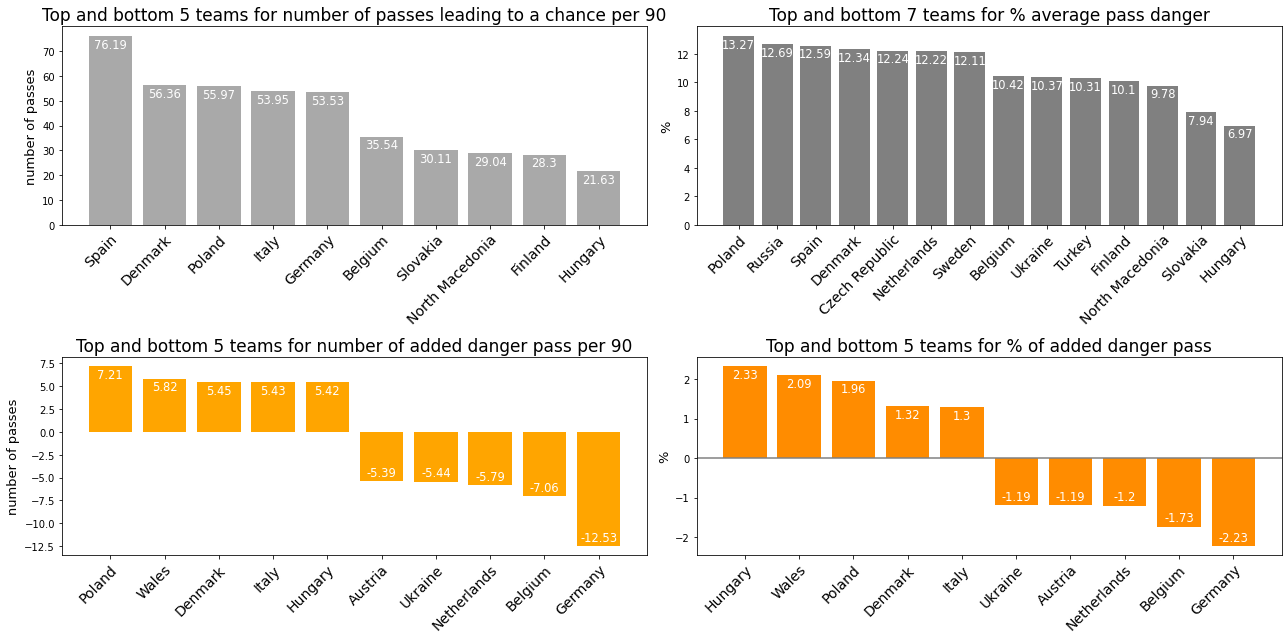

In [172]:
fig, axs = plt.subplots(2, 2, figsize=(18, 9))
sub_plot_team(team_perf, axs[0,0], 
              'pass_lead_chance_p90', 'number of passes leading to a chance per 90', False
              , y_label='number of passes', color='darkgrey')
sub_plot_team(team_perf, axs[0,1], 
              'pass_danger_perc', '% average pass danger', True, 
              top_n=7, color='grey')
sub_plot_team(team_perf, axs[1,0], 
              'x_danger_added_p90', 'number of added danger pass per 90', False, 
              color='orange', y_label='number of passes')
sub_plot_team(team_perf, axs[1,1], 
              'perc_x_danger_add', '% of added danger pass', True, color='darkorange')
plt.axhline(y=0, color='grey', linestyle='-')
fig.tight_layout()
plt.show()

## Player performances
- simlarly we can obtain plots for player performance (we only focus on 4 quarterfinal teams)

In [386]:
semi_finalist = ['England', 'Denmark', 'Italy','Spain']
quarter_finalist = ['Switzerland', 'Ukraine', 'Belgium', 'Czech Republic']

In [314]:
player_pass = group_by(pass_analysis, ['player.name', 'player.id'])
#join with all players to get info
player_pass = player_pass.reset_index().set_index('player.id').rename(columns={'player.id': 'player_id'})
player_minutes = all_player.groupby(['player_id', 'team'])['played_minutes'].sum().reset_index()
player_pass = player_pass.join(player_minutes.set_index('player_id')[['played_minutes','team']])

player_pass

,player.name,x_pass,x_danger,pass_completed,pass_lead_chance,no_dangerous_pass,no_risky_pass,no_risky_pass_completed,count_pass,no_match,x_pass_added,x_danger_added,pass_risk_perc,pass_danger_perc,perc_risky_pass,risky_pass_completion,perc_dangerous_pass,played_minutes,team
player.id,,,,,,,,,,,,,,,,,,,
3517.0,Aaron Ramsey,101.068642,21.203532,103.0,22.0,52.0,54.0,23.0,136.0,4.0,1.931358,0.796468,0.256848,0.155908,0.397059,0.425926,0.382353,363.0,Wales
28239.0,Adam Hložek,16.309303,5.496693,15.0,3.0,14.0,12.0,5.0,23.0,4.0,-1.309303,-2.496693,0.290900,0.238987,0.521739,0.416667,0.608696,94.0,Czech Republic
11333.0,Adama Traoré Diarra,11.920904,2.944098,12.0,2.0,8.0,2.0,1.0,13.0,1.0,0.079096,-0.944098,0.083007,0.226469,0.153846,0.500000,0.615385,18.0,Spain
8219.0,Admir Mehmedi,17.711304,3.480106,18.0,2.0,7.0,6.0,2.0,22.0,2.0,0.288696,-1.480106,0.194941,0.158187,0.272727,0.333333,0.318182,50.0,Switzerland
3026.0,Adrien Rabiot,147.919817,19.814928,146.0,20.0,45.0,30.0,16.0,167.0,4.0,-1.919817,0.185072,0.114253,0.118652,0.179641,0.533333,0.269461,321.0,France
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21567.0,İbrahim Halil Dervişoğlu,3.411124,1.387081,3.0,2.0,4.0,3.0,0.0,6.0,2.0,-0.411124,0.612919,0.431479,0.231180,0.500000,0.000000,0.666667,40.0,Turkey
10287.0,İlkay Gündoğan,159.781695,17.805838,161.0,17.0,36.0,15.0,7.0,172.0,3.0,1.218305,-0.805838,0.071037,0.103522,0.087209,0.466667,0.209302,227.0,Germany
30311.0,İrfan Can Kahveci,52.291862,7.587288,50.0,13.0,17.0,16.0,6.0,62.0,3.0,-2.291862,5.412712,0.156583,0.122376,0.258065,0.375000,0.274194,122.0,Turkey


### Add percentage and number of passes per 90

In [435]:
player_pass['perc_x_pass_add'] = player_pass['x_pass_added'] / player_pass['count_pass']
player_pass['perc_x_danger_add'] = player_pass['x_danger_added'] / player_pass['count_pass']
player_pass['perc_pass_completed'] = player_pass['pass_completed'] / player_pass['count_pass']
player_pass['perc_pass_lead_chance'] = player_pass['pass_lead_chance'] / player_pass['count_pass']
player_pass['count_pass_p90'] = player_pass['count_pass']*90/player_pass['played_minutes']
player_pass['x_pass_add_p90'] = player_pass['x_pass_added']*90/player_pass['played_minutes']
player_pass['x_danger_add_p90'] = player_pass['x_danger_added']*90/player_pass['played_minutes']
player_pass['dangerous_pass_p90'] = player_pass['no_dangerous_pass']*90/player_pass['played_minutes']

In [361]:
player_pass

,player.name,x_pass,x_danger,pass_completed,pass_lead_chance,no_dangerous_pass,no_risky_pass,no_risky_pass_completed,count_pass,no_match,...,risky_pass_completion,perc_dangerous_pass,played_minutes,team,perc_x_pass_add,perc_x_danger_add,perc_pass_completed,perc_pass_lead_chance,count_pass_p90,x_pass_add_p90
player.id,,,,,,,,,,,,,,,,,,,,,
3517.0,Aaron Ramsey,101.068642,21.203532,103.0,22.0,52.0,54.0,23.0,136.0,4.0,...,0.425926,0.382353,363.0,Wales,0.014201,0.005856,0.757353,0.161765,33.719008,0.478849
28239.0,Adam Hložek,16.309303,5.496693,15.0,3.0,14.0,12.0,5.0,23.0,4.0,...,0.416667,0.608696,94.0,Czech Republic,-0.056926,-0.108552,0.652174,0.130435,22.021277,-1.253588
11333.0,Adama Traoré Diarra,11.920904,2.944098,12.0,2.0,8.0,2.0,1.0,13.0,1.0,...,0.500000,0.615385,18.0,Spain,0.006084,-0.072623,0.923077,0.153846,65.000000,0.395480
8219.0,Admir Mehmedi,17.711304,3.480106,18.0,2.0,7.0,6.0,2.0,22.0,2.0,...,0.333333,0.318182,50.0,Switzerland,0.013123,-0.067278,0.818182,0.090909,39.600000,0.519653
3026.0,Adrien Rabiot,147.919817,19.814928,146.0,20.0,45.0,30.0,16.0,167.0,4.0,...,0.533333,0.269461,321.0,France,-0.011496,0.001108,0.874251,0.119760,46.822430,-0.538266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21567.0,İbrahim Halil Dervişoğlu,3.411124,1.387081,3.0,2.0,4.0,3.0,0.0,6.0,2.0,...,0.000000,0.666667,40.0,Turkey,-0.068521,0.102153,0.500000,0.333333,13.500000,-0.925030
10287.0,İlkay Gündoğan,159.781695,17.805838,161.0,17.0,36.0,15.0,7.0,172.0,3.0,...,0.466667,0.209302,227.0,Germany,0.007083,-0.004685,0.936047,0.098837,68.193833,0.483029
30311.0,İrfan Can Kahveci,52.291862,7.587288,50.0,13.0,17.0,16.0,6.0,62.0,3.0,...,0.375000,0.274194,122.0,Turkey,-0.036966,0.087302,0.806452,0.209677,45.737705,-1.690718


### Bubble chart 
#### Risk - all player

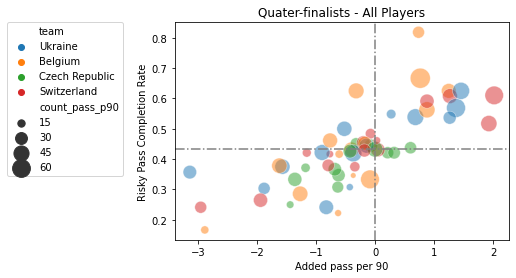

In [420]:
import seaborn as sns
df_all = player_pass.loc[(player_pass['played_minutes']>150)&
                      (player_pass['team'].isin(quarter_finalist))]

sns.scatterplot(data=df_all, y="risky_pass_completion", x="x_pass_add_p90", 
                size="count_pass_p90", 
                hue="team", alpha=0.5, sizes=(30, 400))
plt.axhline(y=df_all['risky_pass_completion'].mean(), color='grey', linestyle='dashdot')
plt.axvline(x=0, color='grey', linestyle='dashdot')
plt.xlabel("Added pass per 90")
plt.ylabel("Risky Pass Completion Rate")
# for i, label in enumerate(df['player.name'].to_list()):
#     plt.text(df['perc_x_pass_add'].to_list()[i], df['risky_pass_completion'].to_list()[i],label)
# show the graph
plt.title('Quater-finalists - All Players')
plt.legend(bbox_to_anchor=(-0.5, 1), loc=2, borderaxespad=0.)

plt.show()

#### Risk - best risky passers

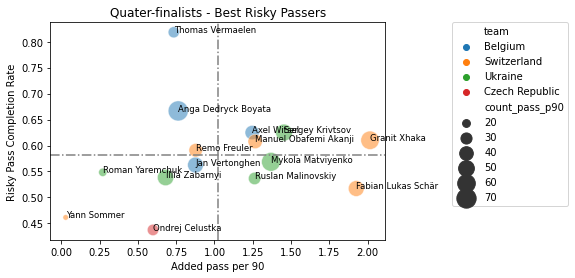

In [419]:
mean_risky_pass_completion = df_all['risky_pass_completion'].mean()
import seaborn as sns
df_best = player_pass.loc[(player_pass['played_minutes']>150)&
                     (player_pass['team'].isin(quarter_finalist))&
                     (player_pass['risky_pass_completion']>mean_risky_pass_completion)&
                     (player_pass['x_pass_add_p90']>0)]

sns.scatterplot(data=df_best, y="risky_pass_completion", x="x_pass_add_p90", 
                size="count_pass_p90", 
                hue="team", alpha=0.5, sizes=(30, 400))
plt.axhline(y=df_best['risky_pass_completion'].mean(), color='grey', linestyle='dashdot')
plt.axvline(x=df_best['x_pass_add_p90'].mean(), color='grey', linestyle='dashdot')
plt.xlabel("Added pass per 90")
plt.ylabel("Risky Pass Completion Rate")
# Put the legend out of the figure
plt.title('Quater-finalists - Best Risky Passers')
plt.legend(bbox_to_anchor=(1.2, 1), loc=2, borderaxespad=0.)
for i, label in enumerate(df_best['player.name'].to_list()):
    if True:#(df_best['x_pass_add_p90'].to_list()[i] >1.25) or (df_best['risky_pass_completion'].to_list()[i]>0.65):
        plt.text(df_best['x_pass_add_p90'].to_list()[i], df_best['risky_pass_completion'].to_list()[i],label, size=8.5)
# show the graph

plt.show()

### Danger
#### Danger all players

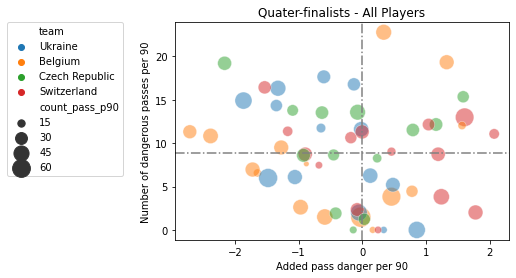

In [438]:
x='x_danger_add_p90'
y='dangerous_pass_p90'
# pass_danger_perc
import seaborn as sns
df_all = player_pass.loc[(player_pass['played_minutes']>150)&
                      (player_pass['team'].isin(quarter_finalist))]

sns.scatterplot(data=df_all, y=y, x=x, 
                size="count_pass_p90", 
                hue="team", alpha=0.5, sizes=(30, 400))
plt.axhline(y=df_all[y].mean(), color='grey', linestyle='dashdot')
plt.axvline(x=0, color='grey', linestyle='dashdot')
plt.xlabel("Added pass danger per 90")
plt.ylabel("Number of dangerous passes per 90")
# for i, label in enumerate(df['player.name'].to_list()):
#     plt.text(df['perc_x_pass_add'].to_list()[i], df['risky_pass_completion'].to_list()[i],label)
# show the graph
plt.title('Quater-finalists - All Players')
plt.legend(bbox_to_anchor=(-0.5, 1), loc=2, borderaxespad=0.)

plt.show()

#### Danger - best danger passers

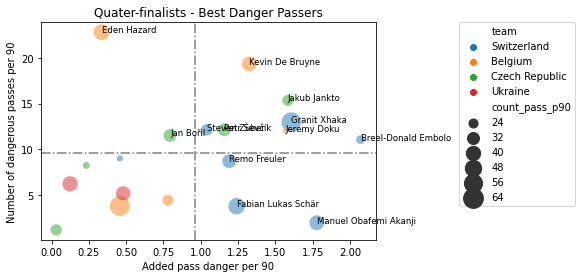

In [445]:
mean_risky_pass_completion = df_all['perc_pass_lead_chance'].mean()
import seaborn as sns
df_best = player_pass.loc[(player_pass['played_minutes']>150)&
                     (player_pass['team'].isin(quarter_finalist))&
                     (player_pass[y]>mean_risky_pass_completion)&
                     (player_pass[x]>0)]

sns.scatterplot(data=df_best, y=y, x=x, 
                size="count_pass_p90", 
                hue="team", alpha=0.5, sizes=(30, 400))
plt.axhline(y=df_best[y].mean(), color='grey', linestyle='dashdot')
plt.axvline(x=df_best[x].mean(), color='grey', linestyle='dashdot')
plt.xlabel("Added pass danger per 90")
plt.ylabel("Number of dangerous passes per 90")
# Put the legend out of the figure
plt.title('Quater-finalists - Best Danger Passers')
plt.legend(bbox_to_anchor=(1.25, 1), loc=2, borderaxespad=0.)
for i, label in enumerate(df_best['player.name'].to_list()):
    if (df_best[x].to_list()[i] >1.1) or (df_best[y].to_list()[i]>10):
        plt.text(df_best[x].to_list()[i], df_best[y].to_list()[i],label, size=8.5)
# show the graph

plt.show()